Introducción: 

En el presente trabajo se desarrollaron modelos mecanicistas de neuronas en python como clases con los métodos necesarios para fijar parámetros, simular y ajustar a una medicion minimizando las tasas de disparo. Se desarrollaron 3 modelos que intentan representar la actividad neuronal, el primero el famoso modelo de Hodgkin y Huxley (HyH), luego el modelo de Leaky Integrate and Fire (LIF) y por último Adaptive Exponential Integrate and Fire ( AdEx). Una vez desarrollados los modelos se probaron sus respuestas frente a distintos estímulos y en que casos un modelo representaba mejor que otro. Por último, se pusieron a prueba los modelos LIF y AdEx en una competencia organizada por “Collaborative Research in Computational Neuroscience” o CRCNS por sus siglas.


In [2]:
#importamos librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.signal import find_peaks
# Paquete de modelos de neuronas
from neuron_models.utils import *
# Importamos los modelos
from neuron_models.adex import Adex_model
from neuron_models.lif import LIF_model

Competencia CRNCS 2009:

Como ya mencionamos en la introducción, esta fue una competencia de neurociencia computacional donde a partir de datos reales de corriente inyectada y tensión medida de una neurona se nos pide que mediante la aplicación de modelos de neuronas lleguemos a predecir la respuesta de la neurona frente a la corriente. El dataset consta de dos archivos “current.txt” y “voltage_allrep.txt”. El primero contenía la corriente inyectada en la neurona, la misma corriente tenía dos fases: una inicial de entrenamiento que constaba de 4 pulsos cuadrados y otra de testeo en forma de ruido.



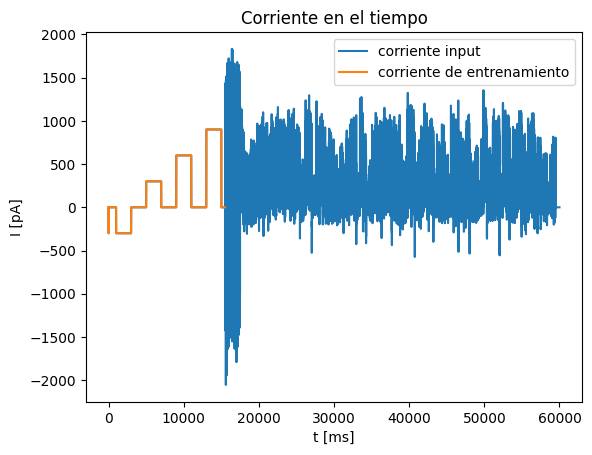

In [3]:
#lectura de archivos
# Leemos la corriente
corrientes = r"dataset/current.txt"
data = np.loadtxt(corrientes, delimiter=',')
I_data= np.loadtxt(corrientes, delimiter=',')*pA

t_max = 60*1e3*ms
train_end_t = 155000
fs = len(I_data-1)/t_max
t_total = np.arange(0, t_max, 1/fs)
t = t_total[:train_end_t]
I_train = I_data[:train_end_t]
I_test = I_data[train_end_t:]

plt.plot(t_total/ms, I_data/pA, label='corriente input')
plt.plot(t/ms, I_train/pA, label='corriente de entrenamiento')
plt.xlabel('t [ms]')
plt.ylabel('I [pA]')
plt.title('Corriente en el tiempo')
plt.legend()
plt.show()

 Por otro lado se nos daba información sobre el comportamiento inicial de la neurona en “volatage_allrep.txt”. Este archivo contiene 12 repeticiones del experimento aunque solo de la etapa inicial de “entrenamiento” del modelo la cual constaba de los primeros 16 segundos de 60 del experimento. Se llevó a cabo la apertura y lectura de ambos datasets y con la ayuda de la función find_peaks de la librería scipy.signal se logró identificar los tiempos de disparos de neuronas para luego utilizarlos para el ajuste del modelo.


In [4]:
# Leemos las mediciones de voltaje
path = r"dataset/voltage_allrep.txt"
headers = [f"rep{i+1}" for i in range(12)]
v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)
v_train = v_data["rep1"][:train_end_t]
v_test = v_data["rep1"][train_end_t:]

C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_15892\2949970621.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)
C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_15892\2949970621.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)


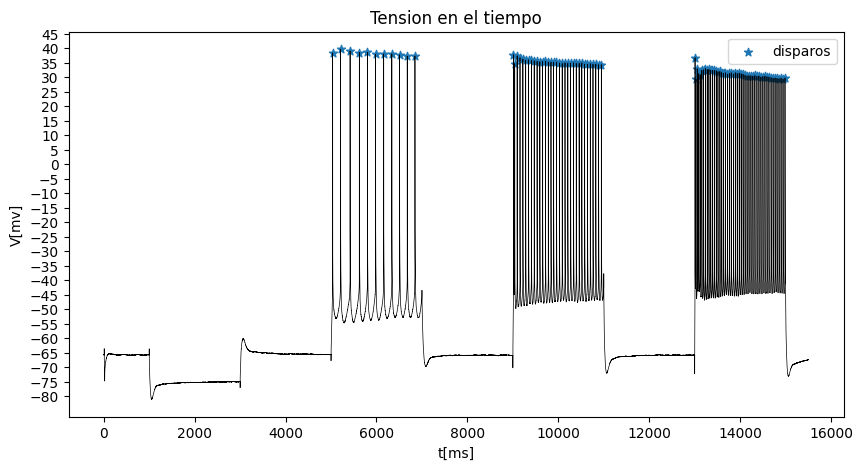

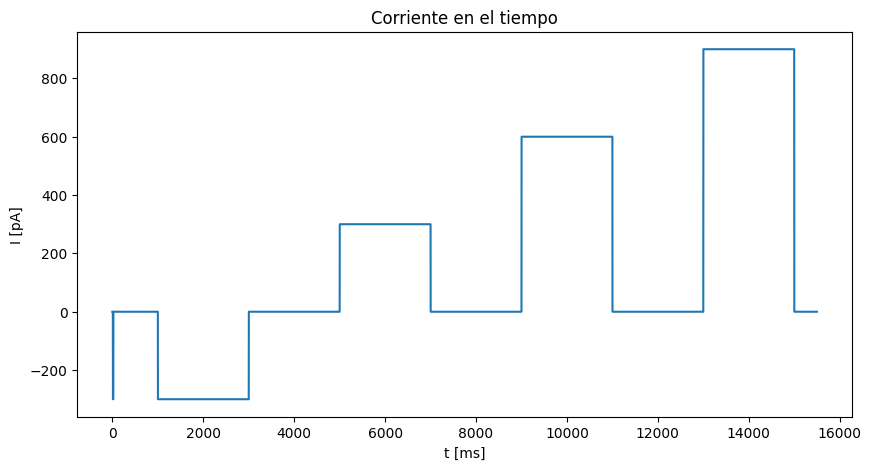

In [5]:
# graficamos
spike_times, training_peaks_h = find_peaks(v_train, height=0)
plt.figure(figsize=(10, 5))
plt.plot(t/ms, v_train, "k-", linewidth=0.5)
plt.scatter(spike_times / (fs * ms), v_train[spike_times], marker="*",label="disparos")
plt.xlabel('t[ms]')
plt.ylabel('V[mv]')
plt.title('Tension en el tiempo')
plt.yticks(np.arange(-80, 50, 5))
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t/ms, I_train/pA)
plt.xlabel('t [ms]')
plt.ylabel('I [pA]')
plt.title('Corriente en el tiempo')
plt.show()